<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Survival-Analysis" data-toc-modified-id="Survival-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Survival-Function---Kaplan-Meier" data-toc-modified-id="Survival-Function---Kaplan-Meier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Survival Function - Kaplan Meier</a></span></li><li><span><a href="#Hazard-Function" data-toc-modified-id="Hazard-Function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Hazard Function</a></span></li><li><span><a href="#Survival-Regression---Cox-Proportional-Hazards" data-toc-modified-id="Survival-Regression---Cox-Proportional-Hazards-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Survival Regression - Cox Proportional Hazards</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Proportional-Hazards-Assumption" data-toc-modified-id="Proportional-Hazards-Assumption-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Proportional Hazards Assumption</a></span></li><li><span><a href="#Deeper-Dive" data-toc-modified-id="Deeper-Dive-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Deeper Dive</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,lifelines

Ethen 2020-03-25 21:59:24 

CPython 3.6.4
IPython 7.9.0

numpy 1.16.5
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1
lifelines 0.18.2


# Survival Analysis

Survival analysis is suite of statistical techniques that are used to **study the time until some event of interest occurs** (often referred to as death since these tools were originally developed to analyze the effect of medical treatment of patents during clinical trials, e.g. keep track of cancer patients in remission over several weeks to see how long they stay in remission). In this post we are interested in how long a customer will stay with the company, so the event of interest will be the customer churn. Unlike typical regression problem where we might be working with a continuous outcome variable, in the survival analysis, the outcome variable has both an event and an associated time value.

The data we'll soon look at tells us which customers have churned, and which ones are still active, or in other words, we haven't observed their churn yet (the event of interest). These customers are considered **censored**. Meaning, while we have some information about their tenure (or survival time), we don't know the full length of their time with the company. This specific type of censorship, one in which we haven't observe the full length of the survival time, is called **right-censorship**.

## Survival Function - Kaplan Meier

Now, to formally define what we're going after: We are interested in a survival function, the probability that a person survives longer than some specified time $t$: The **survival function, $S(t)$**, of a population is defined as follows:

\begin{align}
S(t) = Pr(T > t)
\end{align}

Where $T$ is a random variable that represents a subject's survival time. Survival time refers to the duration of time leading up to the event of interest. In our case, $T$ represents a customer's tenure. Lower case $t$ represents a specific time of interest for $T$. Estimating the survival function will allow us to estimate the probability that someone survives longer than (or at least as long as) a specified value of time, $t$. So in the context of our analysis, S(2) will provide us the probability that a customer stays with the company longer than 2 years.

In this post, we'll start with one such method, called the Kaplan-Meier estimator, to estimate the survival function and construct the survival curve for our customer.

In [2]:
# we can download the customer churn data from the following link
# https://www.kaggle.com/blastchar/telco-customer-churn
path = 'Telco-Customer-Churn.csv'
df = pd.read_csv(path)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# define constant column names
CUSTOMER_ID = 'customerID'
GENDER = 'gender'
SENIOR_CITIZEN = 'SeniorCitizen'
PARTNER = 'Partner'
DEPENDENTS = 'Dependents'
TENURE = 'tenure'
PHONE_SERVICE = 'PhoneService'
MULTIPLE_LINES = 'MultipleLines'
INTERNET_SERVICE = 'InternetService'
ONLINE_SECURITY = 'OnlineSecurity'
ONLINE_BACKUP = 'OnlineBackup'
DEVICE_PROTECTION = 'DeviceProtection'
TECH_SUPPORT = 'TechSupport'
STREAMING_TV = 'StreamingTV'
STREAMING_MOVIES = 'StreamingMovies'
CONTRACT = 'Contract'
PAPERLESS_BILLING = 'PaperlessBilling'
PAYMENT_METHOD = 'PaymentMethod'
MONTHLY_CHARGES = 'MonthlyCharges'
TOTAL_CHARGES = 'TotalCharges'
CHURN = 'Churn'

In [4]:
df[CHURN] = df[CHURN].astype('category')
churn_lookup = df[CHURN].cat.categories
df[CHURN] = df[CHURN].cat.codes

print('churn lookup:', churn_lookup)
df.head()

churn lookup: Index(['No', 'Yes'], dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


To leverage the Kaplan-Meier method, we pass each customer's survival time as the first argument to the `.fit` method and the binary indicator of whether the event of interest occurred.

In [5]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df[TENURE], event_observed=df[CHURN])

<lifelines.KaplanMeierFitter: fitted with 7043 observations, 5174 censored>

After fitting our data we can access the `event_table` that contains a bunch of information regarding the subjects at each time period.

In [6]:
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,11,0,11,7043,7043
1,613,380,233,0,7032
2,238,123,115,0,6419
3,200,94,106,0,6181
4,176,83,93,0,5981


The `removed` column contains the number of observations removed during that time period, whether due to death (the value in the observed column) or censorship. So the removed column is the sum of the `observed` and `censored` columns. The `entrance` column tells us whether any new subjects entered the population at that time period.

The `at_risk` column contains the number of subjects that are still alive during a given time. The value for at_risk at time=0, is just equal to the entrance value. For the remaining time periods, the at_risk value is equal to the difference between the previous period's at_risk value and removed value, plus the current period's entrance value. For example for time=1, the number of subject's at risk is 7,032 which is equal to 7,043 (the previous at_risk value) - 11 (the previous removed value) + 0 (the current period's entrance value).

Let us take a look at the definition of the Kaplan-Meier algo:

\begin{align}
\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}
\end{align}

where $d_i$ are the number of death events at time $t$ and $n_i$ is the number of subjects at risk of death just prior to time $t$.

In [7]:
def surv_from_event_table(event_table, time, at_risk='at_risk', observed='observed'):
    """calculate the survival probability for the specified time"""
    event_at_time = kmf.event_table.iloc[time, :]
    surv_at_time =  (event_at_time[at_risk] - event_at_time[observed]) / event_at_time[at_risk]
    return surv_at_time


# (7032 - 380) / 7032
time = 1
surv_from_event_table(kmf.event_table, time)

0.9459613196814562

For example, by passing in a `time=1`, we are getting back the probability that a customer will stay with the company for 1 year given that the customer did not churn in year 0.

To calculate the probability that a customer will last more than 2 years, we can multiply the three individual survival probabilities at time 0, 1 and 2:

In [8]:
prob = 1.0
for time in range(3):
    prob *= surv_from_event_table(kmf.event_table, time)
    
prob

0.9278349382636624

Our `KaplanMeierFitter` object's `predict` method can perform the above calculations for us. We can get survival probability after a given time by passing in the time we're interested in into the predict method.

In [9]:
kmf.predict(2)

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [2] of <class 'int'>

We can also get the full list of estimated probabilities from our `KaplanMeierFitter` object by accessing the `survival_function_` attribute.

In [ ]:
kmf.survival_function_.head()

Visualizing the above table can also be done by invoking the `.plot` method. The plot belows depicts the property of a survival function: they should decrease with respect to time, $t$.

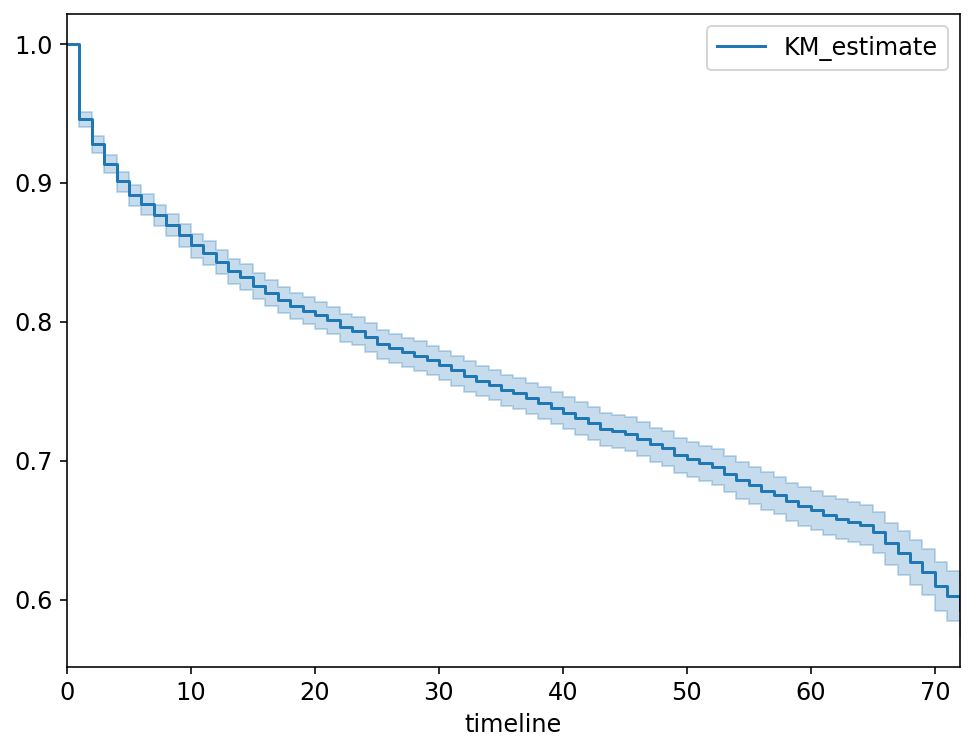

In [10]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

kmf.plot()
plt.show()

We can be use it as an exploratory tool to compare the differences in customer lifetime between cohorts, customer segments. For example, we can use it to compare against customers that have multiples phone lines versus customers that only registered a single phone line.

In [11]:
df.groupby(MULTIPLE_LINES)[MULTIPLE_LINES].count()

MultipleLines
No                  3390
No phone service     682
Yes                 2971
Name: MultipleLines, dtype: int64

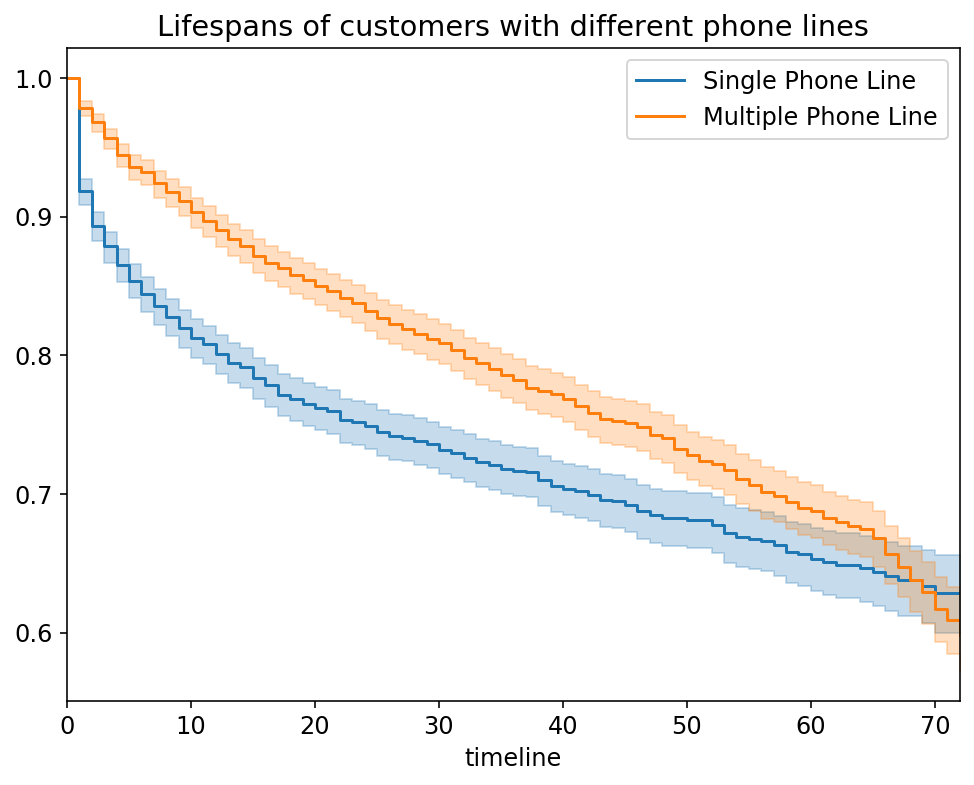

In [12]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for line, label in zip(['No', 'Yes'], ['Single Phone Line', 'Multiple Phone Line']):
    df_subset = df[df[MULTIPLE_LINES] == line]
    kmf.fit(df_subset[TENURE], df_subset[CHURN], label=label)
    kmf.plot(ax=ax)

plt.title("Lifespans of customers with different phone lines")
plt.show()

If we were to interpret this chart, we can see that customers with one phone line have a steeper survival curve initially, but by month 70, the customer lifetime between the two groups becomes quite indistinguishable. As always, correlation does not infer causation, we probably shouldn't jump into conclusion using this graph alone. We can, however, look at this and begin to suspect some possibilities, such as that customers with multiple phone lines are more "locked in" and therefore less likely to churn than single phone line users.

In [13]:
# from lifelines.statistics import logrank_test, multivariate_logrank_test

# logrank_test

Pros and Cons of Kaplan-Meier Curves
Pros:

Minimal feature set needed. Kaplan-Meier only needs the time which event occurred (death or censorship) and the lifetime duration between birth and event.
Many time-series analyses are tricky to implement. Kaplan-Meier only needs all of the events to happen within the same time period of interest
Handles class imbalance automatically (any proportion of deaths-to-censored events is okay)
Because it is a non-parametric method, few assumptions are made about the underlying distribution of the data
Cons:

Cannot estimate the magnitude in difference of the survival-predictor relationship of interest (no hazard ratio or relative risk)
Cannot account for multiple factors simultaneously for each subject in the time to event study, nor control for confounding factors
Assumes independence between censoring and survival, meaning that at time t, those who have been censored should have the same prognosis as those who have not been censored.
Because it is a non-parametric model, it is not as efficient or accurate as competing techniques on problems where the underlying data distribution is known


## Hazard Function

Another quantitative term that's often introduced in survival analysis is the **hazard function, $h(t)$**. In contrast to the survival function, hazard function focuses on the death event occurring. It tells us the potential risk of having an event at time $t$, given that we have survived up to time $t$. Mathematically, this can be denoted as:

\begin{align}
h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t\ |\ T \geq t)}{\Delta t}
\end{align}

Where:

- $P(t \leq T < t + \Delta t\ | \ T \geq t)$, defines the probability that a person's survival time $T$ will be between the time interval $t$ and $t + \Delta t$ given that they have survived up to $t$, $\ T \geq t$.
- $\lim_{\Delta t \to 0}$ indicates as the time interval approaches 0, this will give us the instantaneous measurement at a particular time.


It is important to point out that the hazard is not a probability because we are dividing the probability by a time interval. We instead, get a rate. And since we are dealing with the condition of survival up to time $t$, this is why sometimes the **hazard function is referred to as conditional failure rate**.

## Survival Regression - Cox Proportional Hazards

In [14]:
# define a helper function to help visualize categorical features
from math import ceil


def plot_cat_cols(df, cat_cols, figsize=(16, 16)):
    """
    Visualize the distinct number and the distribution
    of distinct values for the categorical columns of
    a pandas DataFrame.
    """
    label_labelsize = 14
    tick_labelsize = 12
    tick_colors = '#9E9E9E'
    tick_labelcolor = '#424242'
    title_fontsize = 15

    n_plot_cols = 2
    n_plot_rows = ceil(len(cat_cols) / n_plot_cols)
    n_rows = df.shape[0]

    fig = plt.figure(figsize=figsize)
    for idx, cat_col in enumerate(cat_cols, 1):
        ax = plt.subplot(n_plot_rows, n_plot_cols, idx)

        value_counts = df[cat_col].value_counts(dropna=False)
        n_distinct = str(value_counts.shape[0])
        index = np.arange(value_counts.shape[0])

        ax.barh(index, value_counts / n_rows)
        ax.tick_params(labelsize=tick_labelsize, labelcolor=tick_labelcolor, colors=tick_colors)
        ax.set_title(cat_col + '\n number of distinct values: ' + n_distinct, fontsize=title_fontsize)
        ax.set_yticks(index)
        ax.set_yticklabels(value_counts.index)

        # plot style adjustments
        ax.set_facecolor('white')
        ax.get_yaxis().tick_left()
        ax.get_xaxis().tick_bottom()
        for direction in ('top', 'left', 'right', 'bottom'):
            ax.spines[direction].set_visible(False)

        ax.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)

    fig.tight_layout()

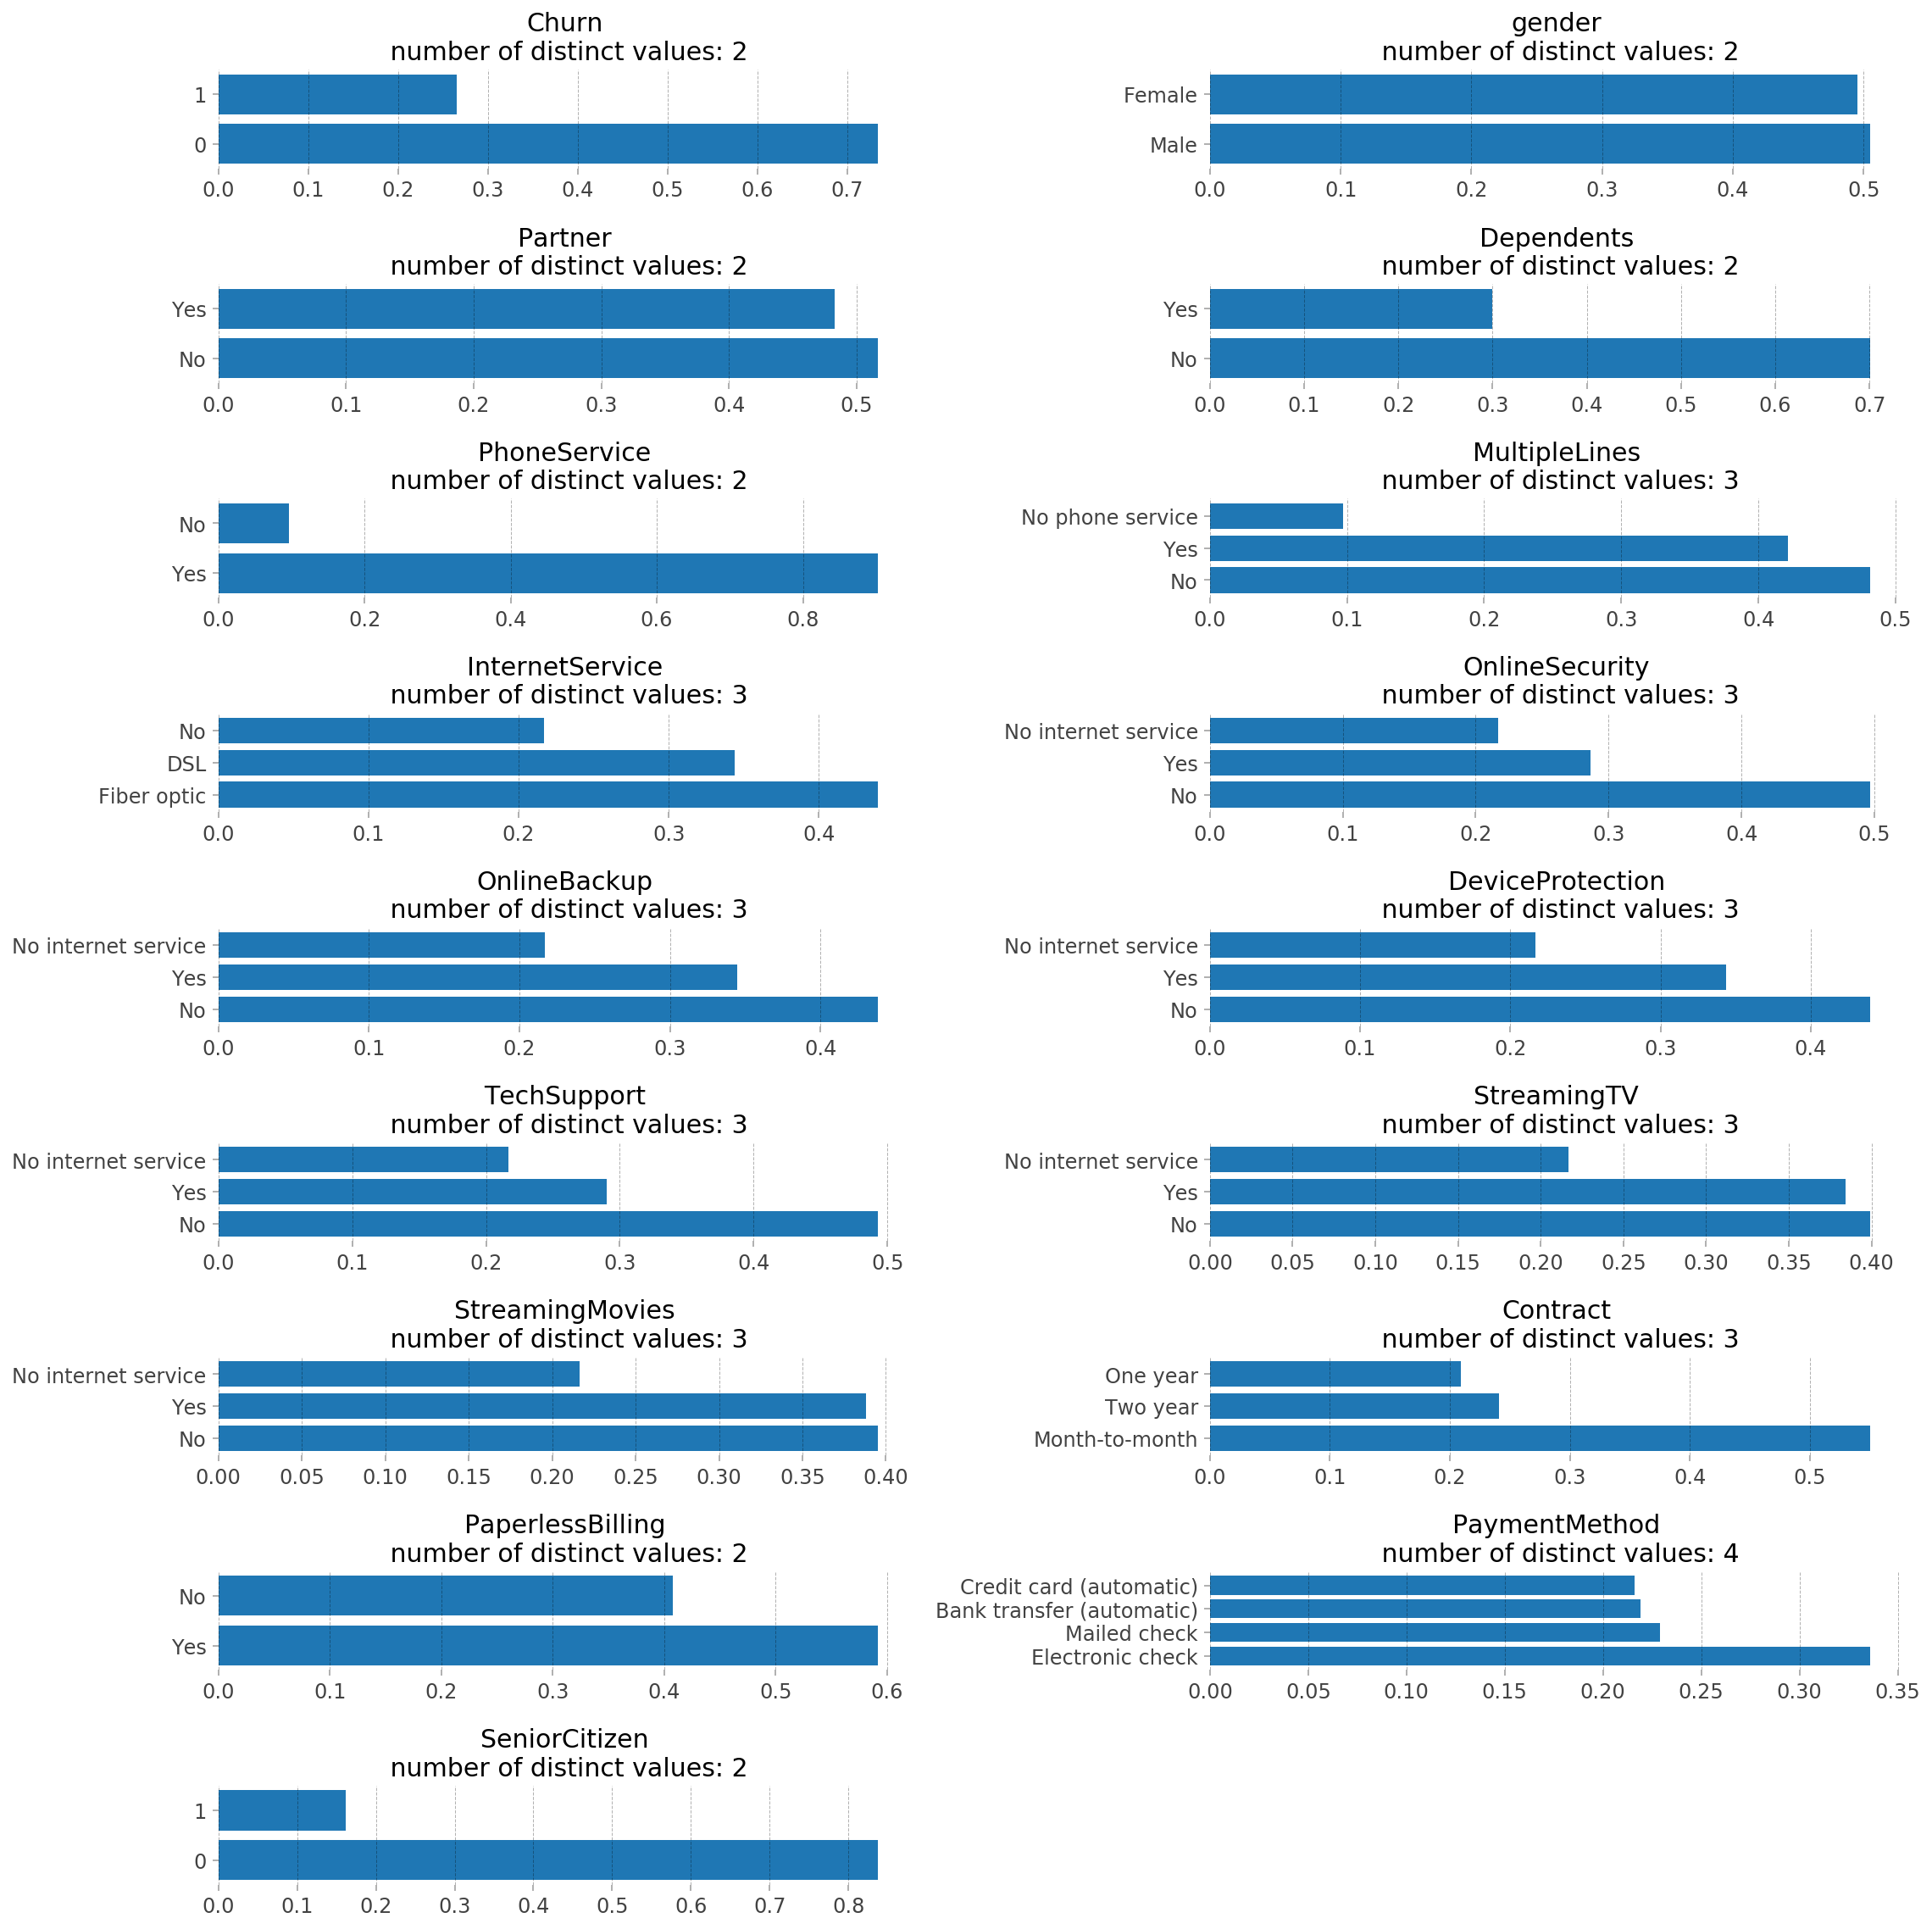

In [15]:
vis_cat_cols = [
    GENDER, PARTNER, DEPENDENTS, PHONE_SERVICE,
    MULTIPLE_LINES, INTERNET_SERVICE, ONLINE_SECURITY,
    ONLINE_BACKUP, DEVICE_PROTECTION, TECH_SUPPORT, STREAMING_TV,
    STREAMING_MOVIES, CONTRACT, PAPERLESS_BILLING,
    PAYMENT_METHOD, SENIOR_CITIZEN
]

plot_cat_cols(df, [CHURN] + vis_cat_cols)

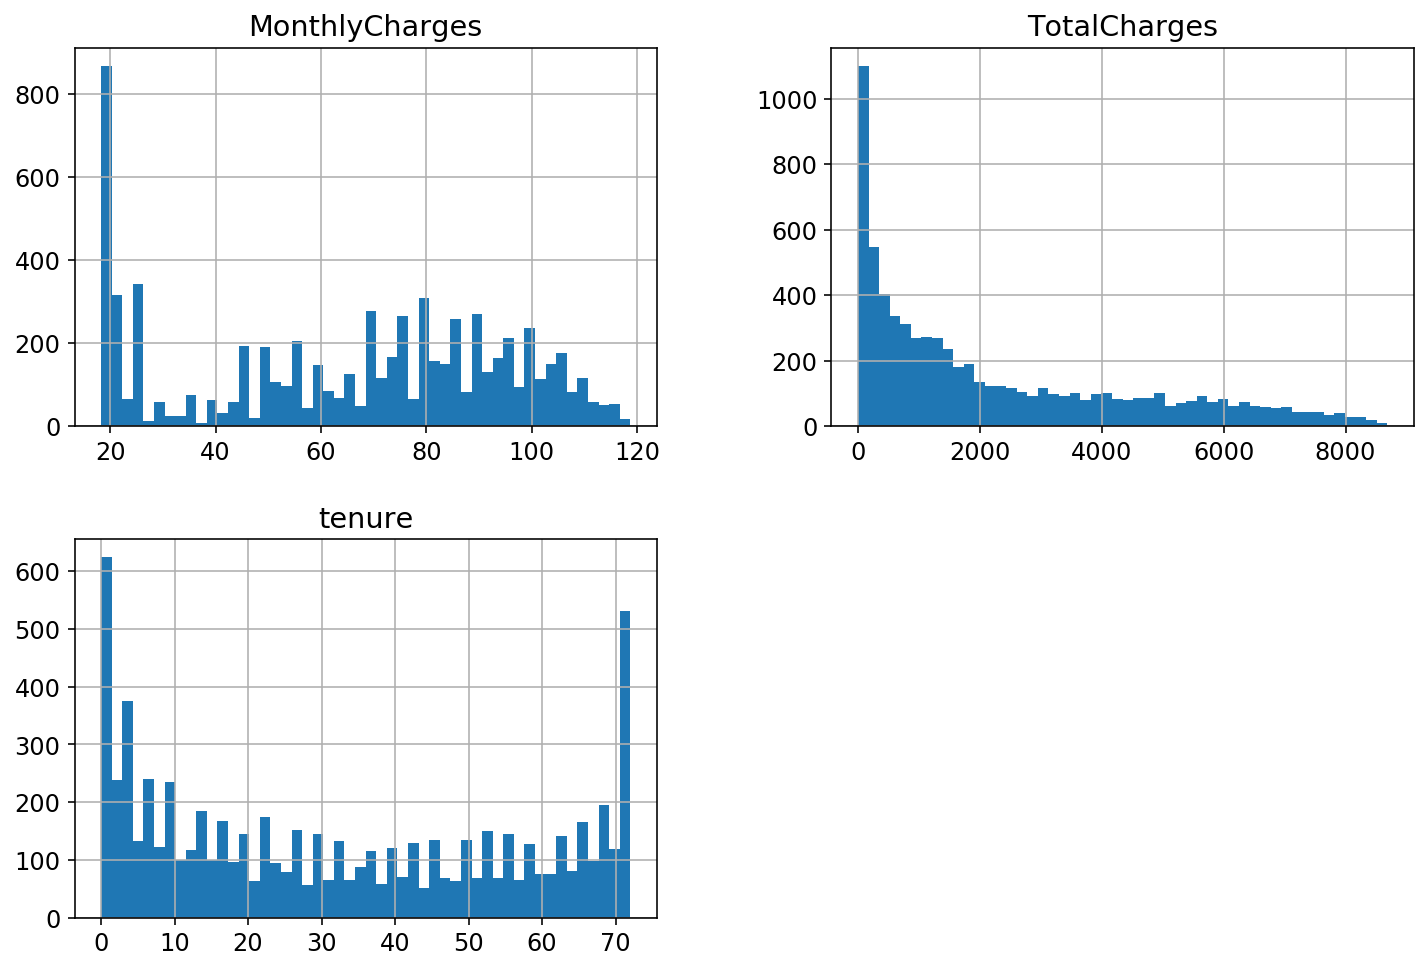

In [16]:
# some of the total charges had ' ' as values, preventing the
# column from being converted into float
df.loc[df[TOTAL_CHARGES] == ' ', TOTAL_CHARGES] = 0.0
df[TOTAL_CHARGES] = df[TOTAL_CHARGES].astype(np.float64)

num_cols = [TOTAL_CHARGES, MONTHLY_CHARGES]
df[num_cols + [TENURE]].hist(bins=50, figsize=(12, 8))
plt.show()

In [17]:
# poor-man's approach of performing one-hot encoding
cat_cols = [
    GENDER, PARTNER, DEPENDENTS, PHONE_SERVICE,
    MULTIPLE_LINES, INTERNET_SERVICE, CONTRACT,
    PAPERLESS_BILLING, PAYMENT_METHOD, SENIOR_CITIZEN
]

df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
data = pd.concat([df[[CUSTOMER_ID, CHURN, TENURE] + num_cols], df_cat], axis=1)
for num_col in num_cols:
    data[num_col] = np.log1p(data[num_col])

data.head()

,customerID,Churn,tenure,TotalCharges,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,3.429137,3.429137,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,7.544597,4.059581,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,2,4.692723,4.004602,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,7.518471,3.768153,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,9237-HQITU,1,2,5.028148,4.272491,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0


In [18]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=1234)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_num = scaler.fit_transform(data_train[num_cols])
data_train_num = pd.DataFrame(data_train_num, columns=num_cols)

data_train = data_train.drop(num_cols, axis=1).reset_index(drop=True)
data_train = pd.concat([data_train, data_train_num], axis=1)
data_train.head()

,customerID,Churn,tenure,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges
0,2558-BUOZZ,0,47,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0.954976,0.896690
1,2277-BKJKN,0,71,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1.252766,0.973904
2,9795-NREXC,0,64,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,1.076852,0.711133
3,2024-BASKD,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,-1.673439,0.489510
4,1657-DYMBM,0,53,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0.051823,-1.721220


In [20]:
from sortedcontainers import SortedSet
from sklearn.linear_model import LogisticRegression

y_train = data_train[CHURN]
features = list(SortedSet(data_train.columns) - SortedSet([CUSTOMER_ID, CHURN]))
X_train = data_train[features]
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
X_train.head()

,Contract_One year,Contract_Two year,Dependents_Yes,InternetService_Fiber optic,InternetService_No,MonthlyCharges,MultipleLines_No phone service,MultipleLines_Yes,PaperlessBilling_Yes,Partner_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,SeniorCitizen,TotalCharges,gender_Male,tenure
0,1,0,0,1,0,0.896690,0,1,0,0,0,0,0,1,0,0.954976,1,47
1,0,1,0,1,0,0.973904,0,0,1,1,0,1,0,1,1,1.252766,0,71
2,0,1,0,0,0,0.711133,0,1,1,1,1,0,0,1,0,1.076852,0,64
3,0,0,0,1,0,0.489510,0,0,1,0,0,0,1,1,0,-1.673439,0,1
4,0,1,0,0,1,-1.721220,0,0,0,1,1,0,0,1,0,0.051823,1,53


In [22]:
def vis_coef(estimator, feature_names, topn=10):
    """
    Visualize the top-n most influential coefficients
    for linear models.

    Parameters
    ----------
    estimator : sklearn-like linear model
        An estimator that contains the attribute
        ``coef_``.

    feature_names : str 1d array or list[str]
        Feature names that corresponds to the coefficients.

    topn : int, default 10
        Here topn refers to the largest positive and negative coefficients,
        i.e. a topn of 10, would show the top and bottom 10, so a total of
        20 coefficient weights.
    """
    fig = plt.figure()
    n_classes = estimator.coef_.shape[0]
    feature_names = np.asarray(feature_names)
    for idx, coefs in enumerate(estimator.coef_, 1):
        sorted_coefs = np.argsort(coefs)
        positive_coefs = sorted_coefs[-topn:]
        negative_coefs = sorted_coefs[:topn]
        top_coefs = np.hstack([negative_coefs, positive_coefs])

        colors = ['#A60628' if c < 0 else '#348ABD' for c in coefs[top_coefs]]
        y_pos = np.arange(2 * topn)
        fig.add_subplot(n_classes, 1, idx)
        plt.barh(y_pos, coefs[top_coefs], color = colors, align = 'center')
        plt.yticks(y_pos, feature_names[top_coefs])
        plt.title('top {} positive/negative coefficient'.format(topn))

    plt.tight_layout()

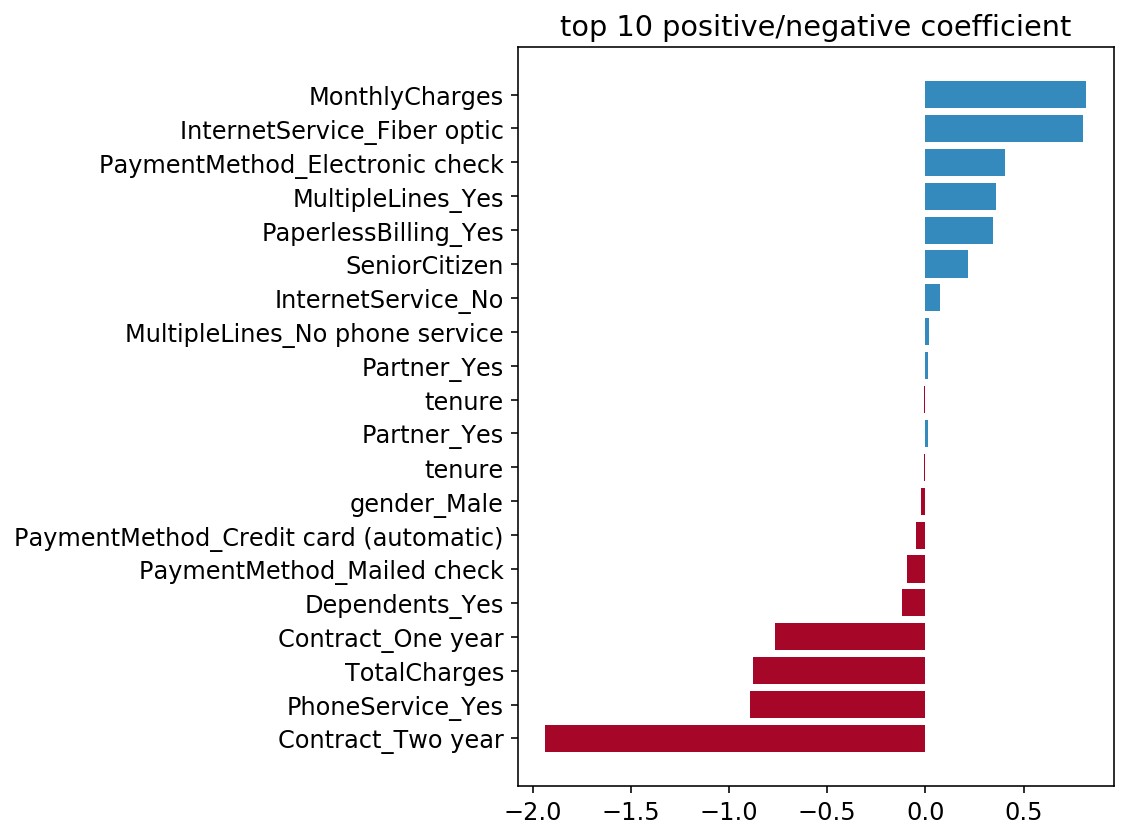

In [23]:
vis_coef(logistic, X_train.columns)

The **Cox PH (Proportional Hazard)** model's form is listed below:


\begin{align}
\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{h_0(t)}^{\text{baseline hazard}} \cdot \underbrace{\exp \left(\sum_{i=1}^p b_i x_i \right)_{\text{partial hazard}}}
\end{align}

Where $x$ denotes the explanatory variables, $b$ denotes each explanatory variables' coefficient.

If we take a look at the formula above, it's saying the hazard at time $t$ is dependent on two factors:

- A baseline hazard that involves time, $t$ but not explanatory variables, $x$.
- Another linear factor that depends on $x$, but not $t$. Taking the exponent ensures that the fitted model will always give estimated hazards that are non-negative.

What's interesting about this formulation is that the baseline hazard is an unspecified function, which is why Cox model is often times referred to as a semi-parametric model.

In [24]:
from lifelines import CoxPHFitter


# unlike scikit-learn, we pass in all the features and labels together
# as our input data
cph = CoxPHFitter(penalizer=0.05)
cph.fit(data_train.drop(CUSTOMER_ID, axis=1), duration_col=TENURE, event_col=CHURN, show_progress=True)

Iteration 1: norm_delta = 4.51237, step_size = 0.9500, ll = -12282.37906, newton_decrement = 3362.95066, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.11779, step_size = 0.9500, ll = -9096.60209, newton_decrement = 639.46568, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.75139, step_size = 0.9500, ll = -8298.80746, newton_decrement = 360.39480, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.43695, step_size = 0.9310, ll = -7843.11216, newton_decrement = 169.47656, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.48393, step_size = 0.6843, ll = -7640.62891, newton_decrement = 34.18402, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.34588, step_size = 0.8047, ll = -7606.46939, newton_decrement = 5.98531, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.40095, step_size = 0.9500, ll = -7599.19432, newton_decrement = 0.34938, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.02544, step_size = 0.9500, ll = -7598.40808, newton_decrement = 0.00138,

<lifelines.CoxPHFitter: fitted with 5634 observations, 4128 censored>

In [25]:
cph.summary

,coef,exp(coef),se(coef),z,p,-log2(p),lower 0.95,upper 0.95
SeniorCitizen,0.093101,1.097572e+00,0.063494,1.466285,1.425708e-01,2.810250,-0.031346,0.217547
gender_Male,-0.025985,9.743500e-01,0.051981,-0.499888,6.171542e-01,0.696297,-0.127866,0.075896
Partner_Yes,-0.077338,9.255771e-01,0.062849,-1.230526,2.185002e-01,2.194294,-0.200520,0.045845
Dependents_Yes,-0.059758,9.419926e-01,0.077393,-0.772134,4.400349e-01,1.184310,-0.211445,0.091930
PhoneService_Yes,-0.282961,7.535490e-01,10.732547,-0.026365,9.789664e-01,0.030669,-21.318366,20.752444
MultipleLines_No phone service,0.282961,1.327054e+00,10.732547,0.026365,9.789664e-01,0.030669,-20.752444,21.318366
MultipleLines_Yes,0.199147,1.220362e+00,0.063216,3.150262,1.631240e-03,9.259815,0.075246,0.323048
InternetService_Fiber optic,0.499496,1.647891e+00,0.109431,4.564485,5.007226e-06,17.607557,0.285015,0.713977
InternetService_No,-0.349063,7.053489e-01,0.237024,-1.472688,1.408351e-01,2.827921,-0.813622,0.115496
Contract_One year,-0.868096,4.197502e-01,0.106794,-8.128713,4.338733e-16,51.033576,-1.077407,-0.658784


From the `.summary` attribute given by the model, we can observe the hazard rate for each of our explanatory variable, which is given by the `exp(coef)` column. For example, we can see that customers having multiple lines has a hazard rate 1.22x that of customers that have a single phone line.

## XGBoost

In [42]:
import shap
import xgboost as xgb

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [49]:
X_train = data_train[features]
X_test = data_test[features]
y_train = data_train[CHURN].values
y_test = data_test[CHURN].values

# create a train/test split
dmatrix_train = xgb.DMatrix(X_train, label=y_train)
dmatrix_test = xgb.DMatrix(X_test, label=y_test)

In [55]:
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

# create a train/test split
dmatrix_train_censored = xgb.DMatrix(X_train, label=y_train)
dmatrix_test_censored = xgb.DMatrix(X_test, label=y_test)

In [56]:
params = {
    "eta": 0.01,
    "max_depth": 5,
    "objective": "survival:cox",
    "subsample": 0.9
}
evals = [(dmatrix_train_censored, 'train'), (dmatrix_test_censored, 'test')]
cox_model = xgb.train(params, dmatrix_train_censored, 100, evals=evals, verbose_eval=10)
cox_model.predict(dmatrix_train_censored)[:5]

[0]	train-cox-nloglik:8.61967	test-cox-nloglik:7.23973
[10]	train-cox-nloglik:8.48835	test-cox-nloglik:7.16264
[20]	train-cox-nloglik:8.40049	test-cox-nloglik:7.11986
[30]	train-cox-nloglik:8.33718	test-cox-nloglik:7.08551
[40]	train-cox-nloglik:8.28967	test-cox-nloglik:7.05866
[50]	train-cox-nloglik:8.25345	test-cox-nloglik:7.03734
[60]	train-cox-nloglik:8.22505	test-cox-nloglik:7.02197
[70]	train-cox-nloglik:8.20246	test-cox-nloglik:7.00474
[80]	train-cox-nloglik:8.18423	test-cox-nloglik:6.99738
[90]	train-cox-nloglik:8.16886	test-cox-nloglik:6.99153
[99]	train-cox-nloglik:8.15754	test-cox-nloglik:6.98944


array([0.8217358 , 0.31159213, 0.20570807, 3.9067676 , 0.2033847 ],
      dtype=float32)

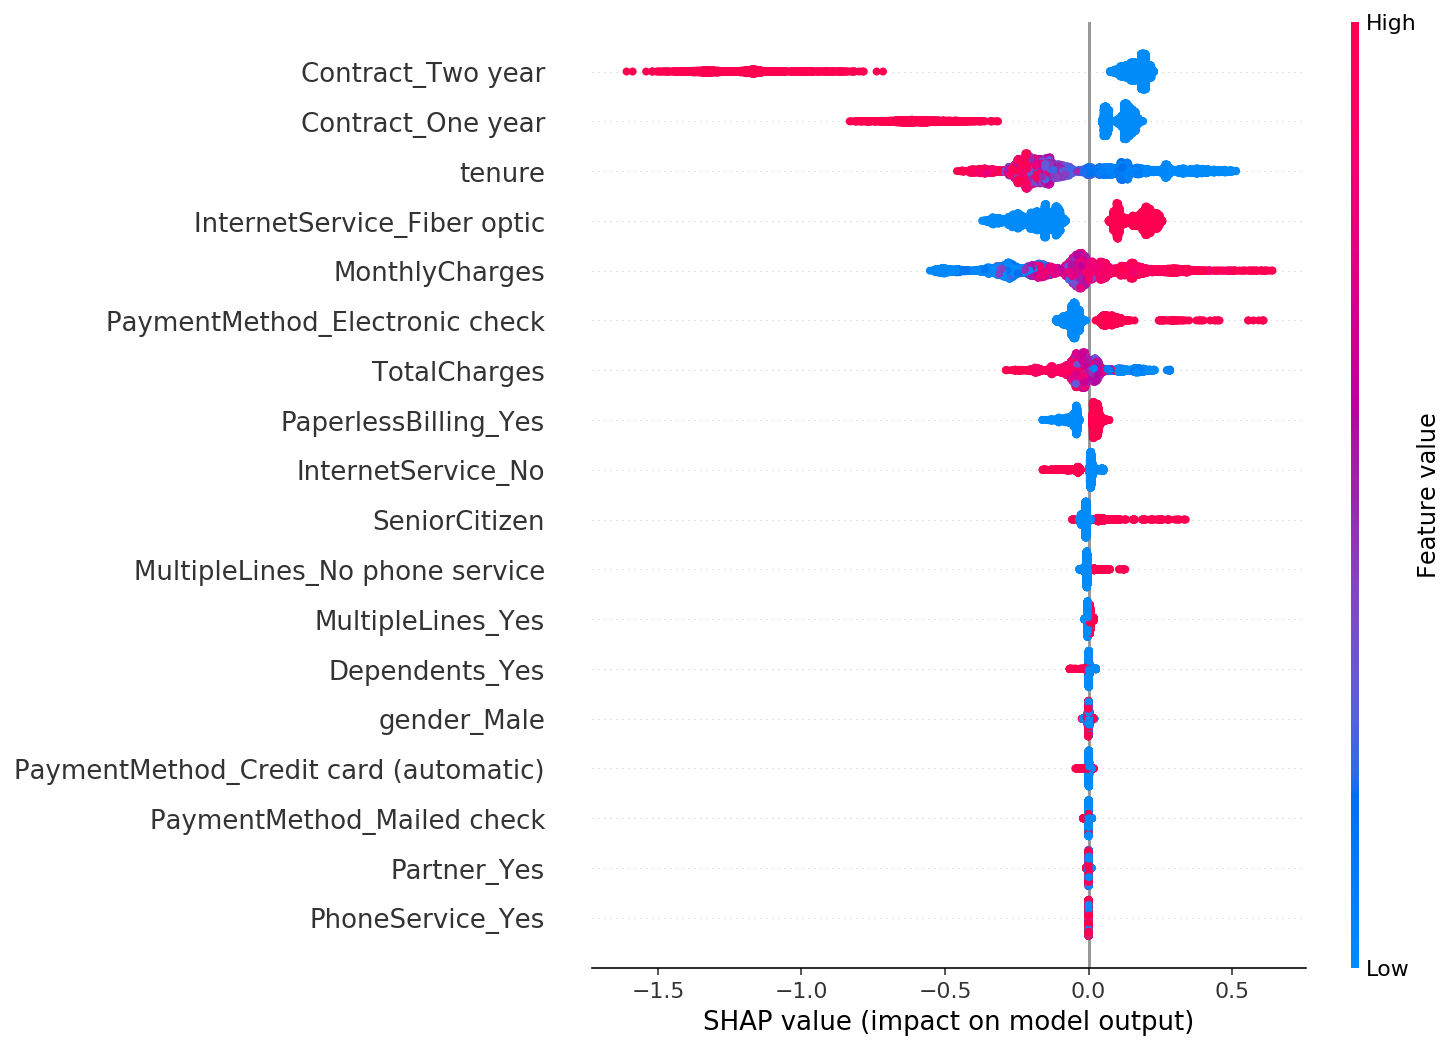

In [57]:
shap_values = shap.TreeExplainer(cox_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [63]:
y_test

array([-1, -1, -1, ...,  1,  1, -1], dtype=int8)

In [51]:
params = {
    "eta": 0.1,
    "max_depth": 5,
    "objective": "binary:logistic",
    "subsample": 0.9
}
evals = [(dmatrix_train, 'train'), (dmatrix_test, 'test')]
binary_model = xgb.train(params, dmatrix_train, 100, evals=evals, verbose_eval=10)
binary_model.predict(dmatrix_train)[:5]

[0]	train-error:0.195421	test-error:0.222853
[10]	train-error:0.186013	test-error:0.216466
[20]	train-error:0.184949	test-error:0.217175
[30]	train-error:0.180511	test-error:0.225692
[40]	train-error:0.177139	test-error:0.245564
[50]	train-error:0.171636	test-error:0.246274
[60]	train-error:0.169329	test-error:0.262598
[70]	train-error:0.165247	test-error:0.276082
[80]	train-error:0.160987	test-error:0.28247
[90]	train-error:0.157259	test-error:0.273243
[99]	train-error:0.15442	test-error:0.275373


array([0.11915352, 0.02681181, 0.01309057, 0.87104475, 0.00556762],
      dtype=float32)

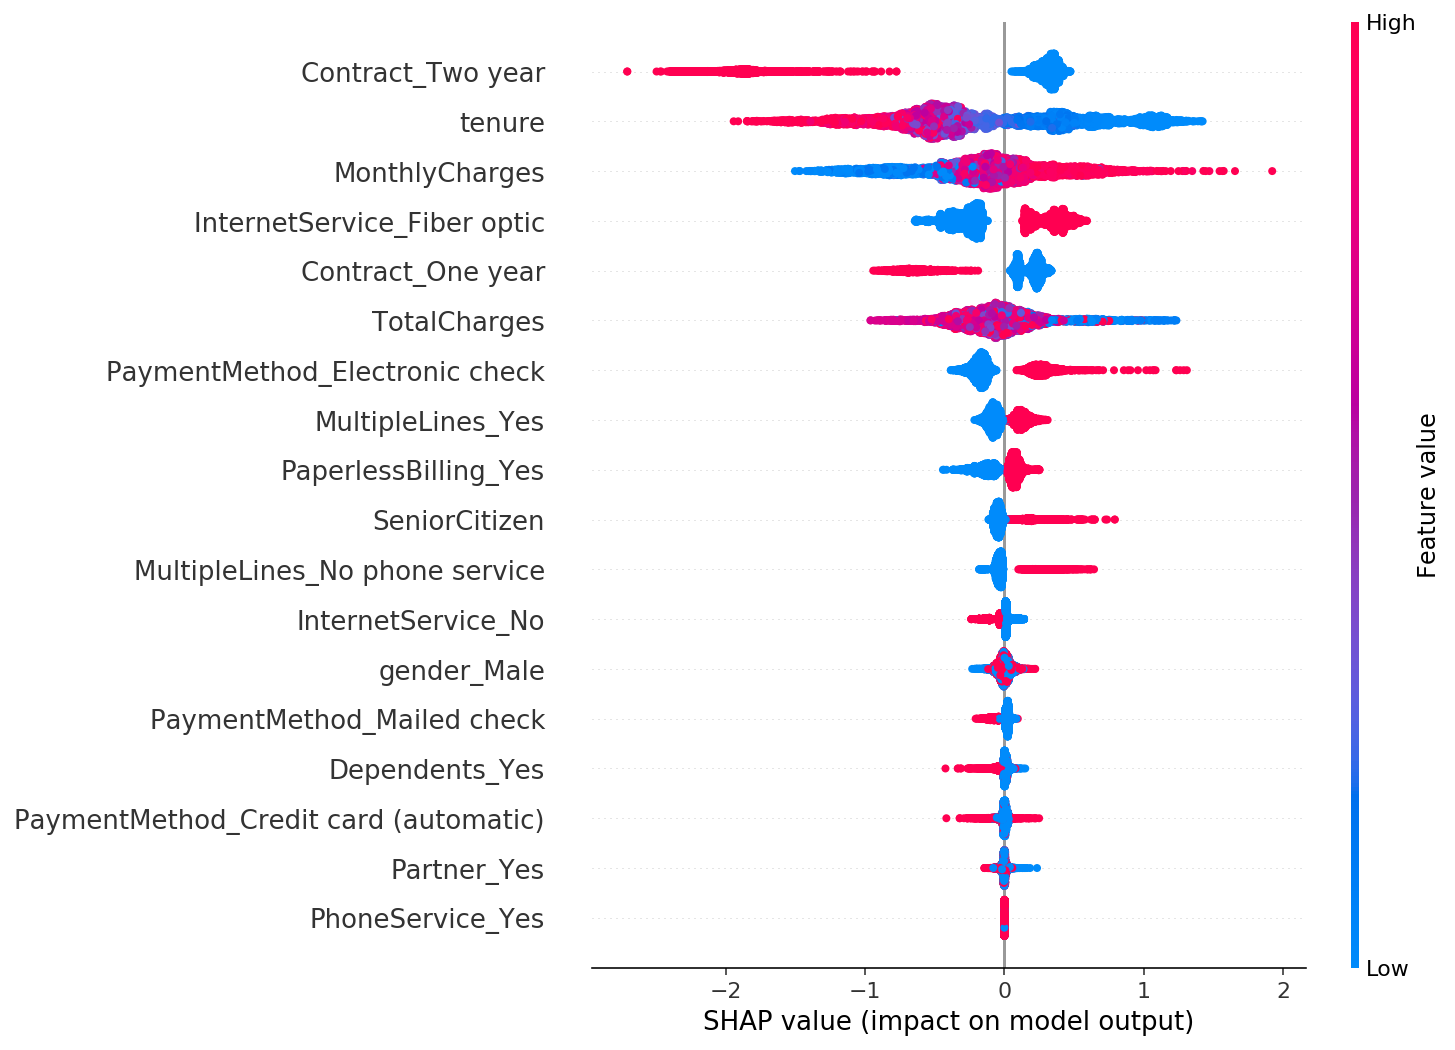

In [54]:
shap_values = shap.TreeExplainer(binary_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Proportional Hazards Assumption

Now that we've gone through the process of fitting a Cox PH model and dabbled with how to look at the model summary to interpret what the model has learned, let's turned our heads towards the assumption that the model makes. The assumption that Cox PH model makes is that the hazard rate should be constant over time. Or to put it in another way, the hazard for one individual is proportional to the hazard rate of another individual irrespective of time. We'll use $x^*$ and $x$ to denote the set of explanatory variable for two individuals.


\begin{align}
\text{hazard rate} &= \frac{h_0(t) \cdot \exp \left(\sum_{i=1}^p b_i x_i^* \right)}{h_0(t) \cdot \exp \left(\sum_{i=1}^p b_i x_i \right)} \\
  &= \exp \left(\sum_{i=1}^p b_i (x_i^* - x_i) \right)
\end{align}

If we look at the derivation, the baseline hazard that depends on time, $h_0(t)$, cancels out during the division. This illustrates the when we were interpreting the values of the coefficients, saying that multiple lines has a hazard rate 1.22x that of customers that have a single phone line, this proportional hazard rate remains constant throughout time.

## Deeper Dive

In [26]:
# some other attributes provided by the model,
# for example, to access just the coefficents
# of the model, we can use the .hazards_
cph.hazards_

,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges
coef,0.093101,-0.025985,-0.077338,-0.059758,-0.282961,0.282961,0.199147,0.499496,-0.349063,-0.868096,-2.374208,0.210908,-0.011016,0.26579,0.008923,-20.342884,8.155349


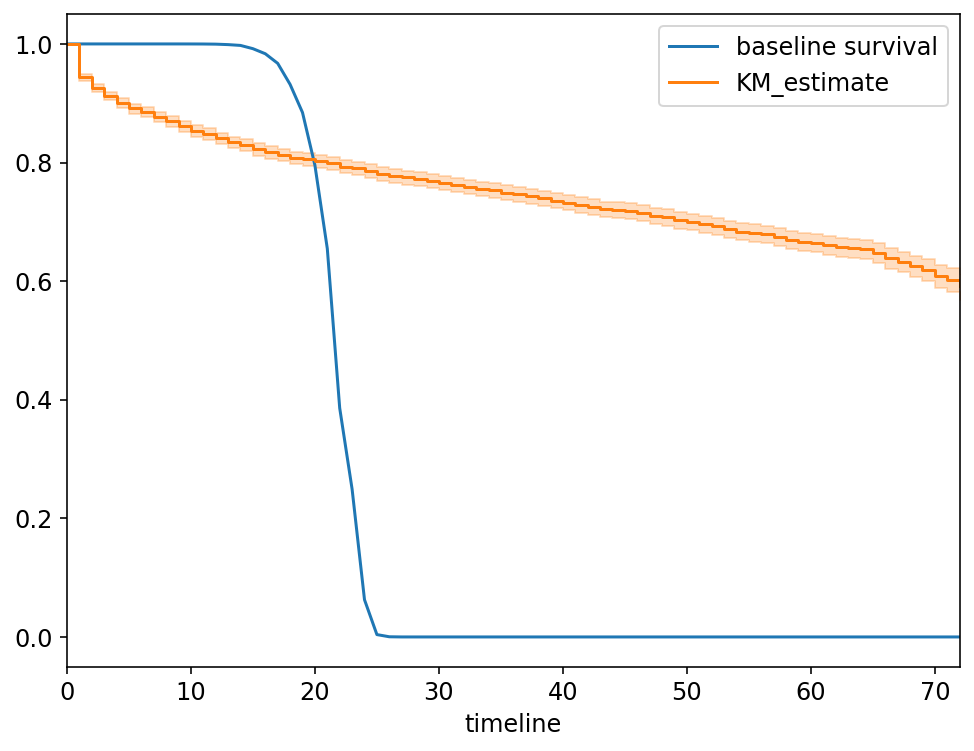

In [27]:
# evaluating the goodness of fit by comparing
# variance from kaplan meier and baseline survival from the Cox PH model
kmf = KaplanMeierFitter()
kmf.fit(durations=data_train[TENURE], event_observed=data_train[CHURN])

ax = cph.baseline_survival_.plot()
kmf.plot(ax=ax)
plt.show()

In [28]:
df_temp = data_train.drop(CUSTOMER_ID, axis=1).copy()
df_temp = df_temp.sort_values(TENURE)
original_index = df_temp.index.copy()

n_examples = df_temp.shape[0]
weights = pd.Series(np.ones(n_examples), index=df_temp.index, name='weights')
T = df_temp.pop(TENURE).astype(float)
E = df_temp.pop(CHURN).astype(bool)
X = df_temp.astype(float)

df_temp.head()

,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges
2993,0,1,1,1,1,0,0,0,1,1,0,1,0,0,1,-4.450093,-1.737753
5382,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,-4.450093,0.005432
3097,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,-4.450093,0.626090
3995,0,1,1,1,1,0,1,0,1,0,1,0,0,0,1,-4.450093,-1.296881
5489,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,-4.450093,-1.692663


In [29]:
def _compute_baseline_hazard(self, X, durations, event_observed, weights, name):
    # https://stats.stackexchange.com/questions/46532/cox-baseline-hazard
    ind_hazards = self.predict_partial_hazard(X) * weights[:, None]
    ind_hazards["event_at"] = durations.values
    ind_hazards_summed_over_durations = (
        ind_hazards.groupby("event_at")[0].sum().sort_index(ascending=False).cumsum()
    )
    ind_hazards_summed_over_durations.name = "hazards"
    event_table = survival_table_from_events(durations, event_observed, weights=weights)
    event_table = event_table.join(ind_hazards_summed_over_durations)
    baseline_hazard = pd.DataFrame(event_table["observed"] / event_table["hazards"], columns=[name]).fillna(0)

    return baseline_hazard

In [30]:
# self.baseline_hazard_ = self._compute_baseline_hazards(X, T, E, weights)
# self._compute_baseline_hazard(X, T, E, weights, name="baseline hazard")

In [31]:
df_temp.iloc[[0]]

,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges
2993,0,1,1,1,1,0,0,0,1,1,0,1,0,0,1,-4.450093,-1.737753


In [32]:
# cph.baseline_hazard_
cph._norm_mean

SeniorCitizen                            1.615193e-01
gender_Male                              5.078097e-01
Partner_Yes                              4.897054e-01
Dependents_Yes                           2.988995e-01
PhoneService_Yes                         9.039759e-01
MultipleLines_No phone service           9.602414e-02
MultipleLines_Yes                        4.178204e-01
InternetService_Fiber optic              4.412496e-01
InternetService_No                       2.195598e-01
Contract_One year                        2.106851e-01
Contract_Two year                        2.392616e-01
PaperlessBilling_Yes                     5.901668e-01
PaymentMethod_Credit card (automatic)    2.106851e-01
PaymentMethod_Electronic check           3.379482e-01
PaymentMethod_Mailed check               2.323394e-01
TotalCharges                             4.501192e-16
MonthlyCharges                          -1.681690e-15
dtype: float64

In [33]:
cph.predict_partial_hazard(df_temp.iloc[0:5])

,0
2993,6.184805e+32
5382,4.165658e+38
3097,3.809163e+40
3995,4.938716e+33
5489,1.733491e+32


In [34]:
cph.baseline_survival_

,baseline survival
event_at,
0.0,1.000000e+00
1.0,1.000000e+00
2.0,1.000000e+00
3.0,1.000000e+00
4.0,1.000000e+00
5.0,1.000000e+00
6.0,1.000000e+00
7.0,9.999996e-01
8.0,9.999979e-01


In [35]:
from lifelines.datasets import load_rossi

rossi = load_rossi()
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [36]:
from lifelines import CoxPHFitter


cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest', show_progress=True)

Iteration 1: norm_delta = 0.48337, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00103, step_size = 0.9500, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00005, step_size = 0.9500, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.00000, step_size = 0.9500, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 6 iterations.


<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

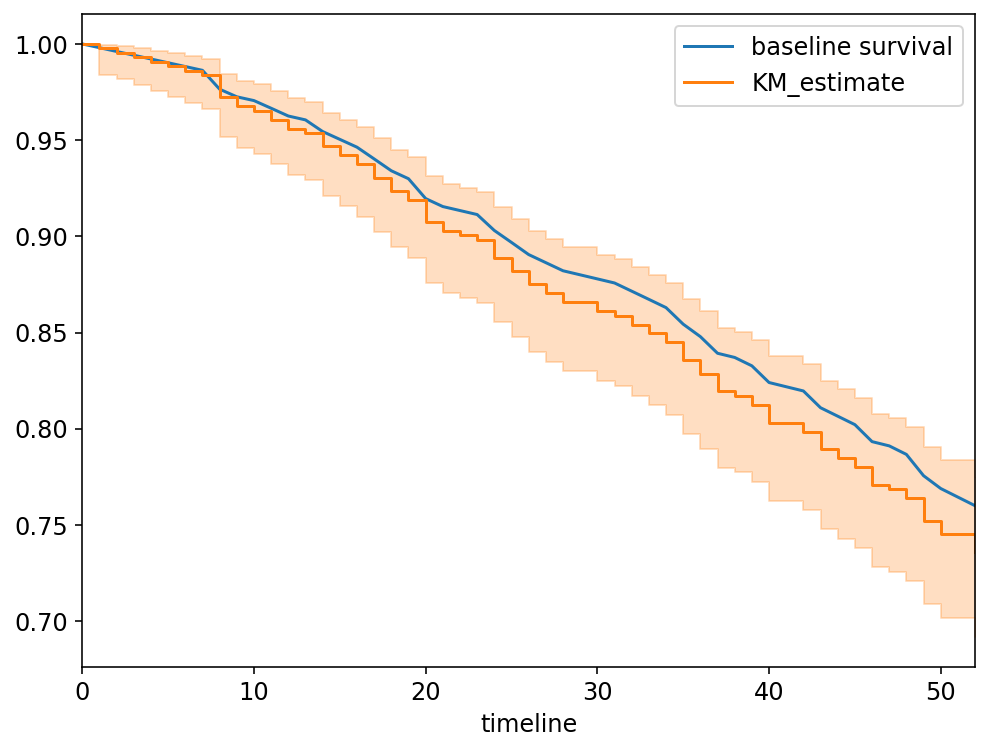

In [37]:
kmf = KaplanMeierFitter()
kmf.fit(rossi['week'], rossi['arrest'])

ax = cph.baseline_survival_.plot()
kmf.plot(ax=ax)

In [38]:
cph.hazards_

,fin,age,race,wexp,mar,paro,prio
coef,-0.379422,-0.057438,0.3139,-0.149796,-0.433704,-0.084871,0.091497


In [39]:
cph.summary

,coef,exp(coef),se(coef),z,p,-log2(p),lower 0.95,upper 0.95
fin,-0.379422,0.684257,0.191379,-1.982564,0.047416,4.398479,-0.754519,-0.004325
age,-0.057438,0.944181,0.021999,-2.610872,0.009031,6.790873,-0.100556,-0.014320
race,0.313900,1.368753,0.307993,1.019179,0.308118,1.698445,-0.289755,0.917555
wexp,-0.149796,0.860884,0.212224,-0.705837,0.480290,1.058023,-0.565748,0.266156
mar,-0.433704,0.648104,0.381868,-1.135744,0.256064,1.965424,-1.182151,0.314743
paro,-0.084871,0.918631,0.195757,-0.433554,0.664612,0.589415,-0.468547,0.298805
prio,0.091497,1.095814,0.028649,3.193782,0.001404,9.476012,0.035347,0.147647


In [40]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2020-03-26 04:59:33 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
fin  -0.38       0.68      0.19 -1.98   0.05      4.40       -0.75       -0.00
age  -0.06       0.94      0.02 -2.61   0.01      6.79       -0.10       -0.01
race  0.31       1.37      0.31  1.02   0.31      1.70       -0.29        0.92
wexp -0.15       0.86      0.21 -0.71   0.48      1.06       -0.57        0.27
mar  -0.43       0.65      0.38 -1.14   0.26      1.97       -1.18        0.31
paro -0.08       0.92      0.20 -0.43   0.66      0.59       -0.47        0.30
prio  0.09       1.10      0.03  3.19 <0.005      9.48        0.04        0.15
---
Concordance = 0.64
Likelihood ratio test = 33.27 on 7 df, -log2(p)=15.37


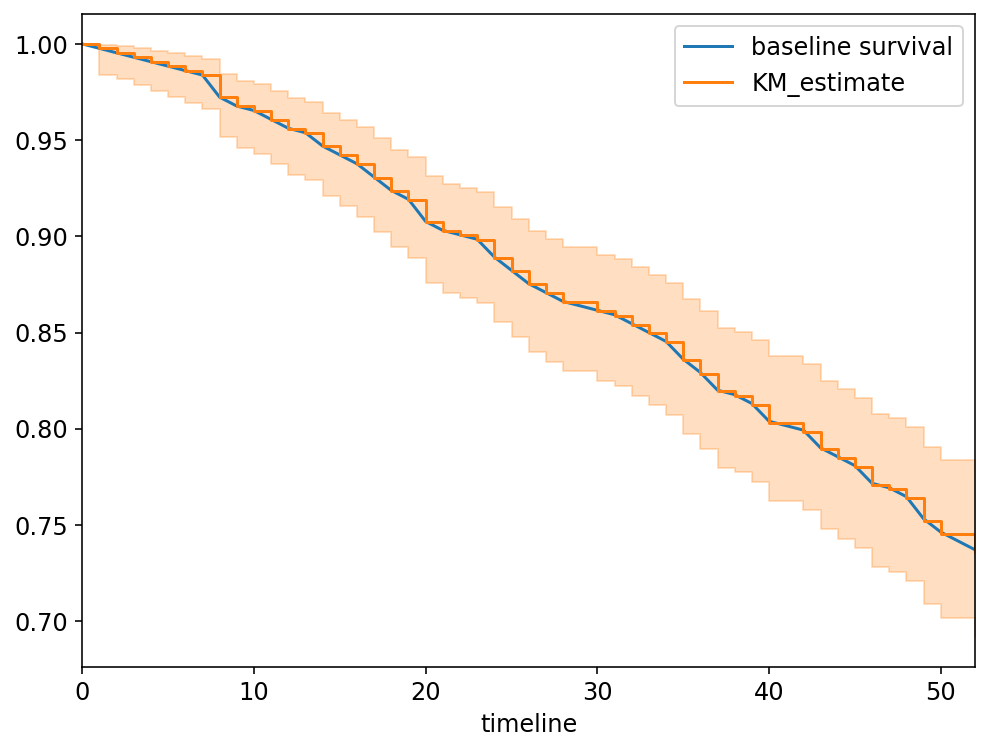

In [41]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter
rossi = load_rossi()
kmf = KaplanMeierFitter()
kmf.fit(rossi['week'], rossi['arrest'])
rossi2 = rossi[['week', 'arrest']].copy()
rossi2['var1'] = np.random.randn(432)
cph = CoxPHFitter()
cph.fit(rossi2, 'week', 'arrest')
ax = cph.baseline_survival_.plot()
kmf.plot(ax=ax)

# Reference

- [Documentation: Survival analysis with lifelines](https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html)
- [Blog: Surviving the NFL - Survival Analysis using Python](http://savvastjortjoglou.com/nfl-survival-analysis-kaplan-meier.html)
- [Blog: Survival Analysis to Explore Customer Churn in Python](https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822)
- [Online Book: Survival Analysis A Self-Learning Text](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.472.2636&rep=rep1&type=pdf)